### Example of a first neural net on images, modified from Hands-On ML with Scikit-Learn, Keras & TensorFlow

In [1]:
import torch
from torch import nn
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch import optim
import matplotlib.pyplot as plt
from torch_snippets import Report
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
print(torch.__version__)
#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

1.13.1


### Let's start by loading the training set of fashion MNIST. PyTorch has a number of functions to load popular datasets in 'torchvision.datasets'. The training set contains 60,000 grayscale images, each 28x28 pixels.

In [3]:
trainset = datasets.FashionMNIST(root='./images',train=True,transform=None,download=True)

In [4]:
prep = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,),(0.5,),)   
])


class FMNistDataset():
    def __init__(self, dataset, transform=None): 
        self.dataset   = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.dataset)

Images are 28x28x1
Class of the image:  Bag


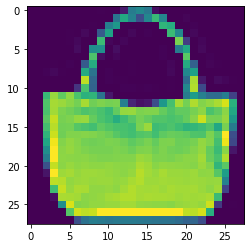

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

dataset   = FMNistDataset(trainset,prep)
(image, target) = dataset[100]
nchannels = image.shape[0]
height    = image.shape[1]
width     = image.shape[2]
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", class_names[target])
plt.show()

### Let's split our training set into training, validationm and test sets by creating one data loader for each. 

In [6]:
indices      = list(range(len(dataset)))
train_sample = SubsetRandomSampler(indices[:30000])
valid_sample = SubsetRandomSampler(indices[30000:45000])
test_sample  = SubsetRandomSampler(indices[45000:])
trainloader  = DataLoader(dataset,sampler=train_sample,batch_size=64)
validloader  = DataLoader(dataset,sampler=valid_sample,batch_size=64)
testloader   = DataLoader(dataset,sampler=test_sample,batch_size=64)

### Create your first NN on images

Since this categorical image classification problem is simple, you may start by flattenning the input images into feature vectors to be the input of an MLP classifier. 

In [7]:
class FMNistNet(nn.Module):

    def __init__(self, input_shape, nclasses=10):
        super(FMNistNet, self).__init__()
        
        #defining a MLP classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_shape[1]*input_shape[2], out_features=300, bias=True),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=300, out_features=100, bias=True),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(100, nclasses)
        )

        #initialize weights
        self.weights_init()

    def forward(self, x):
       #transform image features into a vector   
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y
  
    def weights_init(self):
        for x in self.modules():
            if isinstance(x, nn.Linear):
                torch.nn.init.xavier_uniform_(x.weight.data)
                if (x.bias is not None): 
                    x.bias.data.zero_()
                    

### Build the model and define criterion and optimizer

In [8]:
def Criterion(preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)/pred_labels.size(0)
    return loss, acc
    
# Create the model with cross entropy loss and Adam optimizer
model     = FMNistNet((nchannels,height,width)).to(device=device)
print(model) # presents the architecture of the model
criterion = Criterion
optimizer = optim.Adam(model.parameters(), lr=1e-5)
summary(model, (nchannels, height, width)) # presents the architecture of the model in more details

FMNistNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 300]                 235,500
|    └─ReLU: 2-2                         [-1, 300]                 --
|    └─Dropout: 2-3                      [-1, 300]                 --
|    └─Linear: 2-4                       [-1, 100]                 30,100
|    └─ReLU: 2-5                         [-1, 100]                 --
|    └─Dropout: 2-6                      [-1, 100]                 --
|    └─Linear: 2-7                       [-1, 10]                  1,010
Total param

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Linear: 2-1                       [-1, 300]                 235,500
|    └─ReLU: 2-2                         [-1, 300]                 --
|    └─Dropout: 2-3                      [-1, 300]                 --
|    └─Linear: 2-4                       [-1, 100]                 30,100
|    └─ReLU: 2-5                         [-1, 100]                 --
|    └─Dropout: 2-6                      [-1, 100]                 --
|    └─Linear: 2-7                       [-1, 10]                  1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.02
Estimated Total Size (MB): 1.02

### Train the model and report the results 

In [9]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    return loss.item(), acc.item()

In [10]:
# initializing variables
n_epochs = 40
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainloader)
    for bx, data in enumerate(trainloader):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validloader)
    for bx, data in enumerate(validloader):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)

EPOCH: 10.000	trn_loss: 0.710	trn_acc: 0.760	val_loss: 0.588	val_acc: 0.809	(41.26s - 123.78s remaining)
EPOCH: 20.000	trn_loss: 0.573	trn_acc: 0.804	val_loss: 0.488	val_acc: 0.837	(81.63s - 81.63s remaining)
EPOCH: 30.000	trn_loss: 0.508	trn_acc: 0.823	val_loss: 0.443	val_acc: 0.850	(122.89s - 40.96s remaining)
EPOCH: 40.000	trn_loss: 0.465	trn_acc: 0.835	val_loss: 0.418	val_acc: 0.857	(164.83s - 0.00s remaining)


100%|████████████████████████████████████████| 141/141 [00:00<00:00, 341.32it/s]


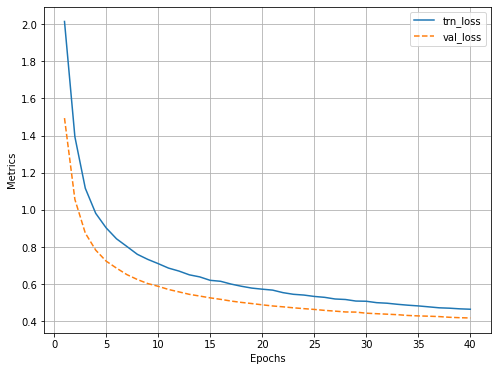

In [11]:
log.plot_epochs(['trn_loss','val_loss'])

100%|████████████████████████████████████████| 141/141 [00:00<00:00, 324.19it/s]


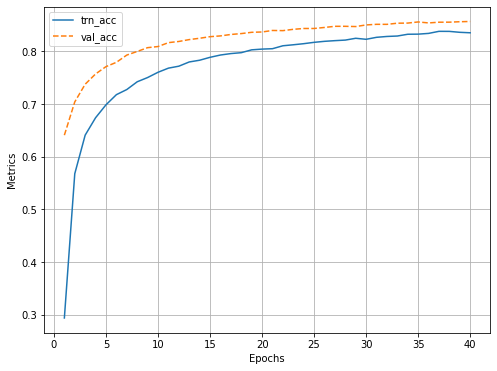

In [12]:
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the NN on the test set

In [13]:
N = len(testloader)
mean_loss = 0
mean_acc  = 0
for bx, data in enumerate(testloader):
    loss, acc  = validate_batch(model, data, criterion, device)
    mean_loss += loss
    mean_acc  += acc
    
mean_loss = mean_loss / N
mean_acc  = mean_acc / N
print('Loss: {:.6f} Acc: {:.6f}'.format(mean_loss,mean_acc))

Loss: 0.424649 Acc: 0.847917


### Save the model

In [14]:
torch.save(model.to('cpu').state_dict(), "FMNistMLP.pth")

#### Exercise: The model is underfitted, which might have to do with the complexity of the model and the proportions among the datasets' sizes. Play with the definition of the training, validation and test sets, network architecture, and hyperparameters to fix the problem without overfitting.